# Basic Neural Analysis of Steinmetz Dataset

This notebook performs basic analyses of neural activity including:
1. PSTH analysis aligned to stimulus and choice
2. Comparison of neural responses across brain regions
3. Analysis of fast-spiking vs regular-spiking neurons
4. Trial-to-trial variability analysis

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader import SteinmetzDataLoader
from neural_analysis import NeuralAnalyzer

# Set plotting style
#plt.style.use('seaborn')
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")

## 1. Data Loading and Setup

## 1. Data Loading and Setup

This section loads and prepares the neural recording data from the Steinmetz dataset. 

- **What it does**: Initializes the data loader and loads a specific recording session (#11), which contains:
  - Spike times from individual neurons
  - Local Field Potentials (LFP) recordings
  - Brain area labels
  - Waveform features

- **Why it matters**: Proper data loading is essential for all subsequent analyses. The Steinmetz dataset contains recordings from multiple brain regions during a visual decision-making task, allowing us to study neural activity across different parts of the mouse brain.

In [2]:
# Initialize data loader and load session
loader = SteinmetzDataLoader()
loader.download_data()
session_data = loader.load_session(11)  # Using session 11 as an example

# Initialize neural analyzer
analyzer = NeuralAnalyzer()

print("Available data keys:", session_data.keys())

Available data keys: dict_keys(['lfp', 'lfp_passive', 'brain_area_lfp', 'waveform_w', 'waveform_u', 'trough_to_peak', 'spikes', 'spikes_passive'])


## 2. PSTH Analysis

## 2. PSTH Analysis

PSTH (Peri-Stimulus Time Histogram) analysis measures how neurons respond to a stimulus over time.

- **What it is**: A PSTH shows the average firing rate of a neuron aligned to an event (e.g., stimulus onset) across multiple trials.

- **How it works**: 
  1. Spike times are aligned relative to stimulus onset (t=0)
  2. Time is divided into small bins (e.g., 10ms)
  3. Spikes are counted in each bin across all trials
  4. Counts are converted to firing rate (spikes/second)

- **Interpretation**: 
  - Peaks in the PSTH indicate increased neural activity in response to the stimulus
  - The timing of the response shows when the neuron processes the stimulus information
  - The shape of the PSTH reflects the neuron's temporal response properties

- **Neuroscience significance**: PSTHs reveal how individual neurons encode stimulus information over time, which is fundamental for understanding sensory processing and decision-making.

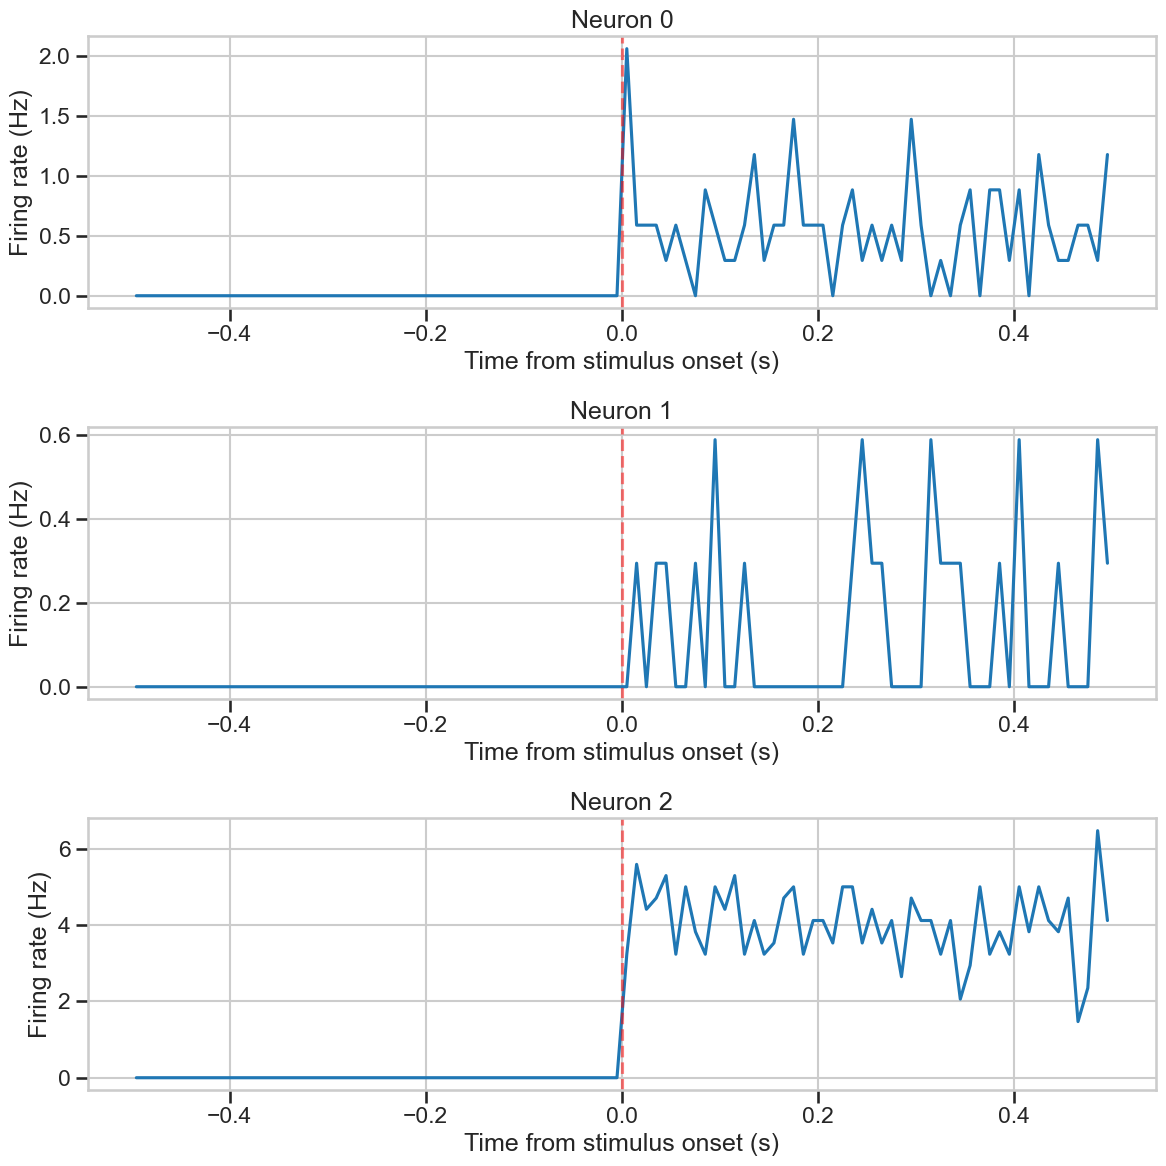

In [3]:
def plot_psth_multiple_neurons(spikes, neuron_indices, time_window=(-0.5, 0.5)):
    """Plot PSTHs for multiple neurons."""
    n_neurons = len(neuron_indices)
    fig, axes = plt.subplots(n_neurons, 1, figsize=(12, 4*n_neurons))
    
    for i, neuron_idx in enumerate(neuron_indices):
        psth, time_bins = analyzer.compute_psth(
            spikes[neuron_idx],
            time_window=time_window
        )
        
        if n_neurons == 1:
            ax = axes
        else:
            ax = axes[i]
            
        ax.plot(time_bins, psth)
        ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)
        ax.set_xlabel('Time from stimulus onset (s)')
        ax.set_ylabel('Firing rate (Hz)')
        ax.set_title(f'Neuron {neuron_idx}')
    
    plt.tight_layout()
    return fig

# Plot PSTHs for first few neurons
example_neurons = [0, 1, 2]
plot_psth_multiple_neurons(session_data['spikes'], example_neurons)
plt.show()

## 3. Neuron Type Analysis

## 3. Neuron Type Analysis

This analysis classifies neurons into different types based on their electrophysiological properties and compares their firing rates.

- **What it is**: Neurons can be categorized into different cell types, including "fast-spiking" (typically inhibitory interneurons) and "regular-spiking" (typically excitatory pyramidal cells).

- **How it works**:
  1. Neurons are classified based on action potential waveform width (trough-to-peak time)
  2. Fast-spiking neurons have narrow spike waveforms (≤10 samples)
  3. Average firing rates are calculated for each neuron
  4. Distributions of firing rates are compared between cell types

- **Interpretation**:
  - Fast-spiking neurons typically have higher firing rates
  - The distributions show differences in activity patterns between neuron types
  - Overlapping distributions indicate shared functions between types

- **Neuroscience significance**: Different neuron types serve distinct computational roles in neural circuits. Inhibitory interneurons (often fast-spiking) regulate network activity, while excitatory neurons (often regular-spiking) transmit information between brain regions. Understanding their different activity patterns helps reveal how neural circuits process information.

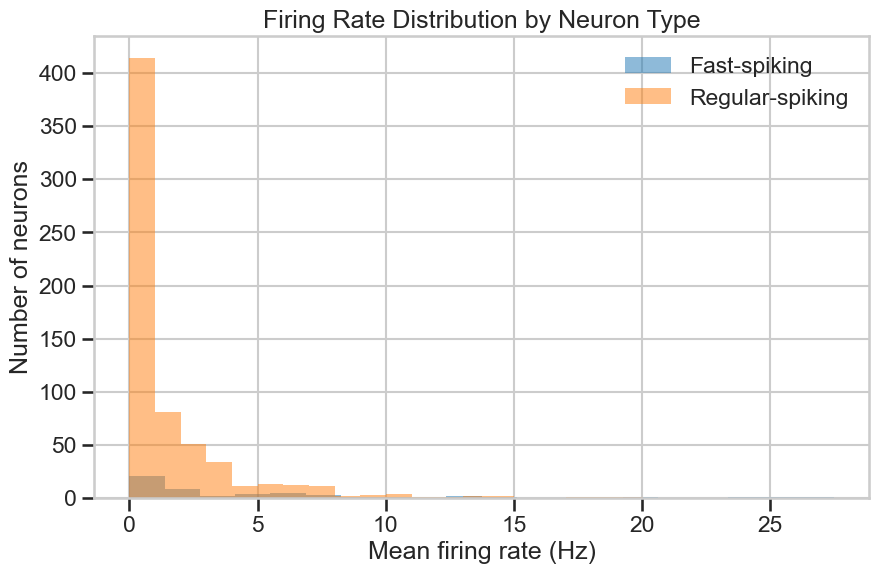

In [4]:
# Identify fast-spiking neurons
is_fast_spiking = loader.get_fast_spiking_neurons(session_data)

# Compute average firing rates
time_bins = np.arange(-0.5, 0.5, 0.01)
firing_rates = loader.compute_firing_rates(session_data['spikes'], time_bins)
mean_rates = np.mean(firing_rates, axis=1)

# Plot firing rate distributions by neuron type
plt.figure(figsize=(10, 6))
plt.hist(mean_rates[is_fast_spiking], bins=20, alpha=0.5, label='Fast-spiking')
plt.hist(mean_rates[~is_fast_spiking], bins=20, alpha=0.5, label='Regular-spiking')
plt.xlabel('Mean firing rate (Hz)')
plt.ylabel('Number of neurons')
plt.title('Firing Rate Distribution by Neuron Type')
plt.legend()
plt.show()

## 4. Trial-to-Trial Variability

## 4. Trial-to-Trial Variability Analysis

This analysis quantifies the consistency of neural responses across repeated stimulus presentations using the Fano Factor.

- **What it is**: The Fano Factor measures response variability by comparing the variance of spike counts to their mean across trials.

- **How it's calculated**:
  1. Count spikes in a fixed time window (e.g., 0-200ms post-stimulus) for each trial
  2. Calculate variance and mean of these counts across trials for each neuron
  3. Fano Factor = Variance / Mean

- **Interpretation**:
  - Fano Factor = 1: Poisson-like variability (variance equals mean)
  - Fano Factor < 1: Sub-Poisson variability (more consistent than Poisson)
  - Fano Factor > 1: Super-Poisson variability (more variable than Poisson)

- **Statistical meaning**: For a Poisson process (random, independent events), the variance equals the mean. Neural activity often shows higher variability (Fano > 1), indicating complex dependencies between spikes.

- **Neuroscience significance**: Trial-to-trial variability affects information transmission reliability. Lower variability suggests more reliable encoding of stimulus features, while higher variability might reflect influence from other brain regions or internal states like attention or arousal.

/var/folders/hy/bsqf9k_s08zb3n3clr6yktm00000gn/T/ipykernel_32380/2885234638.py:3: RuntimeWarning: invalid value encountered in divide
  return np.var(spike_counts, axis=1) / np.mean(spike_counts, axis=1)


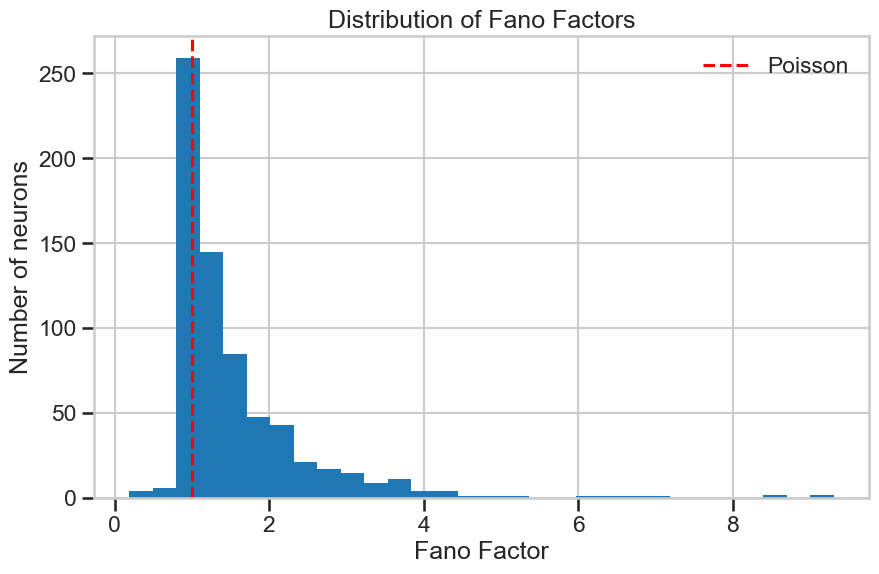

In [5]:
def compute_fano_factor(spike_counts):
    """Compute Fano factor (variance/mean) across trials."""
    return np.var(spike_counts, axis=1) / np.mean(spike_counts, axis=1)

# Compute spike counts in response window
window = (0, 0.2)  # 200ms after stimulus
n_neurons = len(session_data['spikes'])
n_trials = len(session_data['spikes'][0])
spike_counts = np.zeros((n_neurons, n_trials))

for i, neuron_spikes in enumerate(session_data['spikes']):
    for j, trial_spikes in enumerate(neuron_spikes):
        spike_counts[i, j] = np.sum(
            (trial_spikes >= window[0]) & (trial_spikes < window[1])
        )

# Compute and plot Fano factors
fano_factors = compute_fano_factor(spike_counts)

plt.figure(figsize=(10, 6))
plt.hist(fano_factors, bins=30)
plt.axvline(x=1, color='r', linestyle='--', label='Poisson')
plt.xlabel('Fano Factor')
plt.ylabel('Number of neurons')
plt.title('Distribution of Fano Factors')
plt.legend()
plt.show()

## 5. Response Reliability Analysis

## 5. Response Reliability Analysis

This analysis measures how consistently a neuron's temporal response pattern is reproduced across different sets of trials.

- **What it is**: Response reliability quantifies the reproducibility of a neuron's temporal firing pattern by measuring the correlation between the average responses from two halves of the trials.

- **How it's calculated**:
  1. Split trials into two groups
  2. Calculate average firing rate over time for each group
  3. Compute correlation coefficient between these two average responses

- **Interpretation**:
  - Values close to 1: Highly reliable responses (similar patterns across trial groups)
  - Values close to 0: Unreliable responses (patterns differ between groups)
  - Values close to -1: Inverted responses (rare in neural data)

- **Statistical meaning**: This is essentially a split-half reliability measure, which estimates how well we can predict a neuron's response pattern from one set of trials to another.

- **Neuroscience significance**: Neurons with high reliability likely play important roles in consistent sensory encoding or motor control. Reliability can vary with brain region, neuron type, and behavioral context, providing insights into how different neural circuits maintain stable representations despite inherent biological noise.

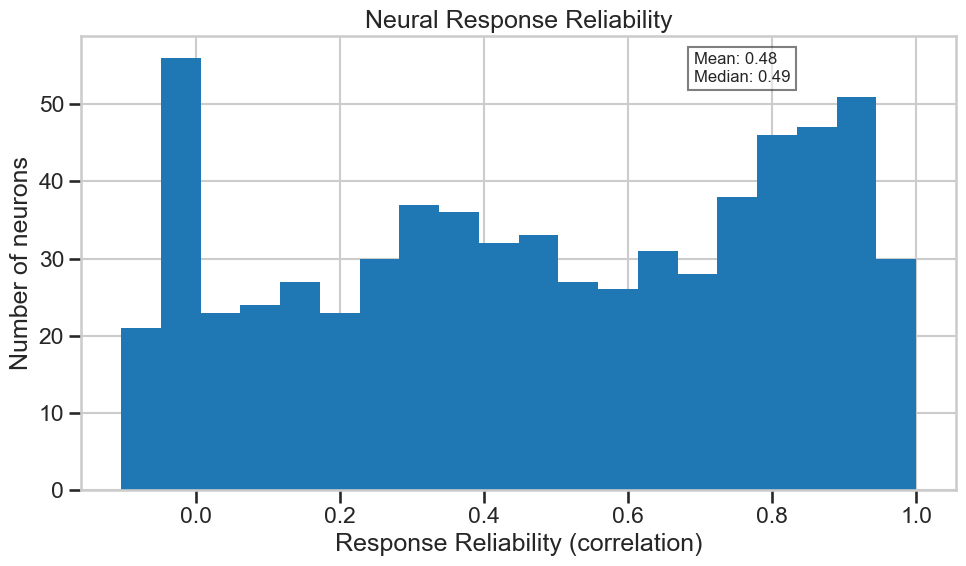

Valid neurons: 666 out of 698


In [8]:
# Prepare the data for trial-by-trial analysis
def create_trial_specific_firing_rates(spikes, time_bins):
    """Create firing rates for each neuron and trial."""
    n_neurons = len(spikes)
    n_trials = len(spikes[0])  # Assuming all neurons have same number of trials
    n_time_bins = len(time_bins) - 1
    
    # Initialize array (neurons × trials × time bins)
    trial_rates = np.zeros((n_neurons, n_trials, n_time_bins))
    
    for i in range(n_neurons):
        for j in range(n_trials):
            trial_spikes = spikes[i][j]
            # Only compute histogram if there are spikes
            if len(trial_spikes) > 0:
                counts, _ = np.histogram(trial_spikes, bins=time_bins)
                # Convert to firing rate
                bin_width = time_bins[1] - time_bins[0]
                trial_rates[i, j] = counts / bin_width
    
    return trial_rates

# Create trial-specific firing rates
time_bins = np.arange(-0.5, 0.5, 0.01)
trial_rates = create_trial_specific_firing_rates(session_data['spikes'], time_bins)

# Now compute reliability
def compute_response_reliability(trial_rates):
    """Compute response reliability (correlation between trial subsets)."""
    n_neurons = trial_rates.shape[0]
    n_trials = trial_rates.shape[1]
    reliability = np.zeros(n_neurons)
    
    # Need at least 2 trials for reliability measure
    if n_trials < 2:
        return np.full(n_neurons, np.nan)
    
    # Split trials in half
    half = n_trials // 2
    
    for i in range(n_neurons):
        # Average across trials for each half
        rates_half1 = np.mean(trial_rates[i, :half], axis=0)
        rates_half2 = np.mean(trial_rates[i, half:], axis=0)
        
        # Only compute correlation if there's variation in both halves
        std1 = np.std(rates_half1)
        std2 = np.std(rates_half2)
        
        if std1 > 0 and std2 > 0:
            # Calculate correlation and handle exceptions
            try:
                reliability[i] = np.corrcoef(rates_half1, rates_half2)[0, 1]
                # If NaN or outside [-1,1], treat as NaN
                if np.isnan(reliability[i]) or reliability[i] < -1 or reliability[i] > 1:
                    reliability[i] = np.nan
            except:
                reliability[i] = np.nan
        else:
            reliability[i] = np.nan
    
    return reliability

# Compute response reliability
reliability = compute_response_reliability(trial_rates)

# Filter out NaN values for plotting
valid_reliability = reliability[~np.isnan(reliability)]

# Plot reliability distribution
plt.figure(figsize=(10, 6))
if len(valid_reliability) > 0:
    plt.hist(valid_reliability, bins=20)
    plt.xlabel('Response Reliability (correlation)')
    plt.ylabel('Number of neurons')
    plt.title(f'Neural Response Reliability')
    # Add statistics as text
    plt.text(0.7, 0.9, f'Mean: {np.mean(valid_reliability):.2f}\nMedian: {np.median(valid_reliability):.2f}',
            transform=plt.gca().transAxes, fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.5))
else:
    plt.text(0.5, 0.5, 'No valid reliability values found', 
            horizontalalignment='center', verticalalignment='center',
            transform=plt.gca().transAxes, fontsize=14)
plt.tight_layout()
plt.show()

# Print summary
print(f"Valid neurons: {len(valid_reliability)} out of {len(reliability)}")